In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import sys
import matplotlib.pyplot as plt
import resource
from IPython.display import display

from genquad.functionfamiliy import Interval
from genquad.testproblems import example_problem, gen_poly_and_sing
from genquad.discretize import adaptive_discretization
from genquad.compress import compress_sequence_of_functions, construct_Chevyshev_quadratures, visualise_diagonal_dropoff
from genquad.optimize import QuadOptimizer

resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

In [2]:
eps_disc = 1e-10
eps_comp = 1e2*eps_disc
eps_quad = 1e-2
I = Interval(1e-6,1)
seed = 0

In [3]:
rng_gen = np.random.default_rng(seed)
F = example_problem(I, number_of_functions = 100, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()

Example function from function space


2.33799873052001*x**10 - 1.75307724354972*x**9 - 6.20799698870532*x**8 - 2.00041294807059*x**7 + 6.23153327726853*x**6 - 2.49304638672892*x**5 + 7.04152550989667*x**4 - 1.9276187936959*x**3 - 0.0649541049969547*x**2 + 6.81325072615779*x - 4.46331404403848 - 0.455611203760929/x

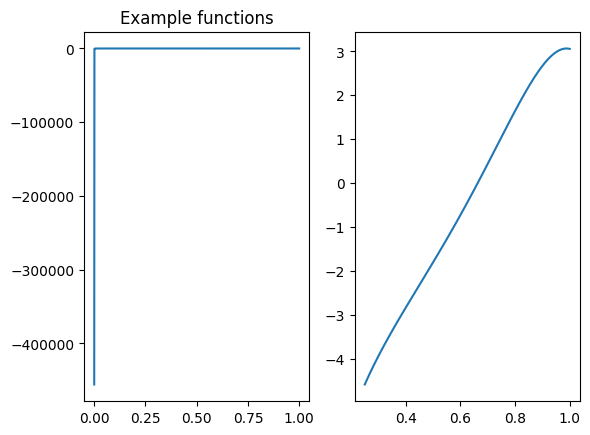

In [4]:
print("Example function from function space")
display(ex_f_expr)
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2);
xx2 = np.linspace((I.a + I.b)/4,I.b,1000)
plt.plot(xx2,ex_f(xx2));

Discretization and compression

In [5]:
k = 30
x_disc, w_disc, endpoints, intervals = adaptive_discretization(F, eps_disc, k, verbose=False)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Functions before compression: 100
Functions after compression: 12


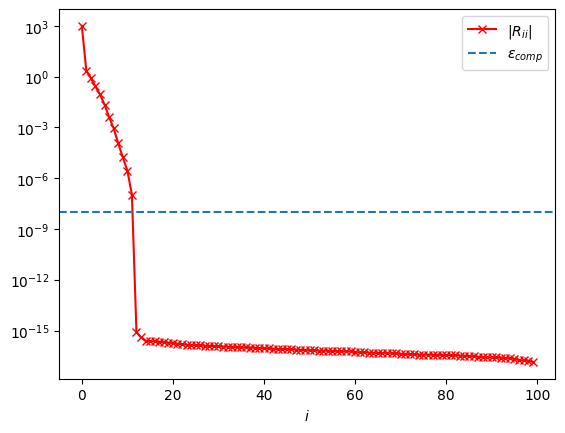

In [6]:
print("Functions before compression:", len(F.functions))
print("Functions after compression:", len(u_list))
visualise_diagonal_dropoff(A, eps_comp)

Chebyshev Rule

In [7]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)

In [8]:
print("Number of points in original discretization:", len(x_disc))
print("Number of points in Chebyshev rule:", len(x_cheb))
print("Absolute integral error for chebyshev:", abs(F.target_integral(ex_f_expr)-ex_f(x_cheb)@w_cheb))

Number of points in original discretization: 1140
Number of points in Chebyshev rule: 12
Absolute integral error for chebyshev: 2.75335310107039e-14


Naive nonlinear optimization

In [9]:
r = U_disc.T@w_disc

In [10]:
opt = QuadOptimizer(u_list,r)
opt.set_parameters(0.8,1000,1e-9)
x_naive, w_naive = opt.naive_optimization(6, F.I)

In [11]:
print("Naive quadrature length: ", len(x_naive))
print("Naive error:", abs(F.target_integral(ex_f_expr)-ex_f(x_naive)@w_naive))

Naive quadrature length:  6
Naive error: 5.11032381555439


In [12]:
opt = QuadOptimizer(u_list,r)
opt.set_parameters(0.9,100,1e-4)
x,w = opt.point_reduction(x_cheb, w_cheb, eps_quad)

In [13]:
print("Quadrature length: ", len(x))
print("Absolute error:", abs(F.target_integral(ex_f_expr)-ex_f(x)@w))

Quadrature length:  6
Absolute error: 3.71383191755115e-7


Comparison with Gauss-Legendre

Gauss-Legendre [0.034 0.169 0.381 0.619 0.831 0.966]
New quadrature [0.003 0.101 0.307 0.563 0.803 0.96 ]


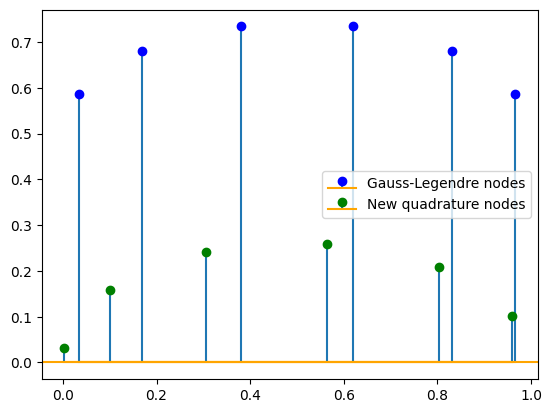

In [14]:
fig, ax = plt.subplots()
x_gl,w_gl = I.translate(np.polynomial.legendre.leggauss(len(x)))
ax.axhline(y=0,c="orange")
ax.stem(x_gl, w_gl, markerfmt = 'bo', basefmt="orange", label=r"Gauss-Legendre nodes")
ax.stem(x, w, markerfmt = 'go', basefmt="orange", label=r"New quadrature nodes")
ax.legend()
print("Gauss-Legendre",np.around(x_gl,3))
print("New quadrature",np.around(sorted(x),3))

In [23]:
symx = sym.Symbol("x")
expr = 2*symx**3 + 0.1*symx**7
f = sym.lambdify(symx, expr, "numpy")
print(abs(F.target_integral(expr) - f(x)@w))


1.54440715771642e-9
